In [3]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from darts import TimeSeries
from darts.models import NLinearModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape
from darts.utils.timeseries_generation import datetime_attribute_timeseries

In [18]:
base_path = 'sample_csv/'
# base_path = 'stock_data_kr/'

column_mapping = {
    '일자': 'date',
    '종가': 'closing_price',
    '대비': 'price_difference',
    '등락률': 'fluctuation_rate',
    '시가': 'opening_price',
    '고가':	'highest_price',
    '저가': 'lowest_price',
    '거래량': 'trading_volume',
    '거래대금': 'trading_value',
    '시가총액': 'market_capitalization',
    '상장주식수': 'listed_shares',
}

In [26]:
stock_df = pd.read_csv(os.path.join(base_path, '005930_삼성전자_20000101_20230331.csv')).rename(columns=column_mapping)

stock_df.head()

,date,closing_price,price_difference,fluctuation_rate,opening_price,highest_price,lowest_price,trading_volume,trading_value,market_capitalization,listed_shares
0,2023/03/31,64000,800,1.27,64000,64000,63700,14094479,900711556583,382066083200000,5969782550
1,2023/03/30,63200,500,0.80,63700,63700,63100,15684377,993903387442,377290257160000,5969782550
2,2023/03/29,62700,-200,-0.32,62500,62700,62200,11216008,700455977590,374305365885000,5969782550
3,2023/03/28,62900,800,1.29,62400,62900,62100,11614118,726295104112,375499322395000,5969782550
4,2023/03/27,62100,-900,-1.43,62600,62800,62000,11039331,687170094400,370723496355000,5969782550


과거 공변량:
<ol>
    <li>과거 주가 데이터: 종가, 시가, 고가, 저가 등
    <li>거래량: 주식 거래량 데이터
    <li>기술적 지표: 이동 평균, RSI (상대 강도 지수), MACD (이동 평균 수렴 발산) 등
    <li>기업 재무 데이터: 매출, 이익, 자산, 부채 등
    <li>배당: 배당금과 배당 수익률
    <li>주가 수익률 (P/E) 등의 가치 지표
</ol>
<br>
미래 공변량:
<ol>
    <li>경제 성장률: 국내 총생산(GDP) 성장률 등
    <li>인플레이션: 소비자 물가지수(CPI) 등
    <li>기준 금리: 중앙은행의 기준 금리
    <li>실업률: 국가의 실업률 데이터
    <li>환율: 외환 시장의 환율 정보
    <li>경제 정책: 정부의 경제 정책이나 중앙은행의 통화 정책
</ol>

In [50]:
# 필터링할 날짜 범위 설정
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2023-03-31')

list_stock_timeseries = []

list_train_series_scaled = []
list_val_series_scaled = []
list_scaler = []

list_cov_scaled = []
list_train_cov_scaled = []
list_val_cov_scaled = []

for i, file_name in enumerate(os.listdir(base_path)):
    df = pd.read_csv(base_path + file_name).rename(columns=column_mapping)
    df['date'] = pd.to_datetime(df['date'])

    # date interpolate
    stock_timeseries_df_interpolated = df.copy()
    stock_timeseries_df_interpolated.set_index('date', inplace=True)
    stock_timeseries_df_interpolated = stock_timeseries_df_interpolated.asfreq('B')
    stock_timeseries_df_interpolated['closing_price'] = stock_timeseries_df_interpolated['closing_price'].interpolate(method='linear')
    stock_timeseries_df_interpolated.reset_index(inplace=True)
    df = stock_timeseries_df_interpolated

    timeseries = TimeSeries.from_dataframe(df, time_col='date', freq='B')
    
    # Darts TimeSeries 변환 및 날짜 필터링
    stock_timeseries = timeseries['closing_price']
    stock_timeseries = stock_timeseries[start_date:end_date]
    list_stock_timeseries.append(stock_timeseries)

    past_cov = getPastCov(stock_timeseries)
    list_cov_scaled.append(past_cov)
    print(past_cov)
    break
    
    train_percentage = 0.8
    split_index = int(train_percentage * len(stock_timeseries))
    train_cov_series, val_cov_series = past_cov[:split_index], past_cov[split_index:]
    list_train_cov_scaled.append(train_cov_series)
    list_val_cov_scaled.append(val_cov_series)
    
    train_series, val_series = stock_timeseries[:split_index], stock_timeseries[split_index:]
    
    scaler = Scaler()
    train_series_scaled = scaler.fit_transform(train_series)
    val_series_scaled = scaler.transform(val_series)
    list_scaler.append(scaler)
    
    list_train_series_scaled.append(train_series_scaled)
    list_val_series_scaled.append(val_series_scaled)
    
    if i % 50 == 49:
        break

price_difference


KeyError: "not all values found in index 'component'"

In [49]:
past_cov_list = ['price_difference', 'fluctuation_rate', 'opening_price', 'highest_price', 'lowest_price', 'trading_volume',
                'trading_value', 'market_capitalization', 'listed_shares']

def getPastCov(timeseries):
    past_cov_timeseries = timeseries.copy()
    cov_year = datetime_attribute_timeseries(past_cov_timeseries, attribute='year')
    cov_month = datetime_attribute_timeseries(past_cov_timeseries, attribute='month')
    past_cov = cov_year.stack(cov_month)
    for col in past_cov_list:
        print(col)
        past_cov.stack(past_cov_timeseries[col])
    return Scaler().fit_transform(past_cov)

def getFutureCov(timeseries):
    pass

In [107]:
model = NLinearModel(input_chunk_length=20, output_chunk_length=5, n_epochs=10, random_state=42)
model.fit(list_train_series_scaled, future_covariates=list_train_cov_scaled)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | criterion      | MSELoss          | 0     
1 | train_metrics  | MetricCollection | 0     
2 | val_metrics    | MetricCollection | 0     
3 | layer          | Linear           | 305   
4 | linear_fut_cov | Linear           | 3     
----------------------------------------------------
308       Trainable params
0         Non-trainable pa

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

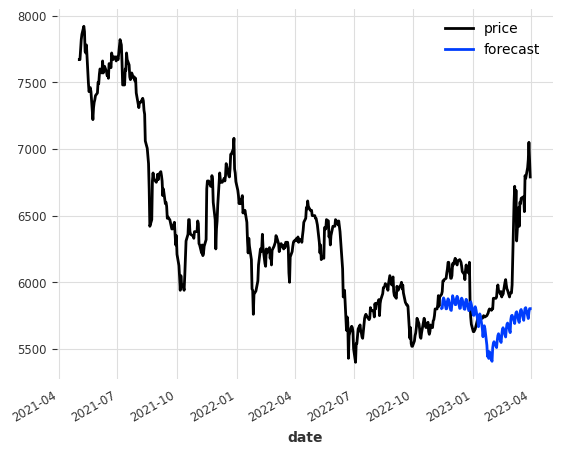

In [109]:
i = 1
predicted_series_scaled = model.predict(n=len(list_val_series_scaled[i]),
                                        series=list_train_series_scaled[i],
                                       future_covariates=list_cov_scaled[i])
prediction = list_scaler[i].inverse_transform(predicted_series_scaled)
list_stock_timeseries[i].plot()
prediction.plot(label="forecast")
plt.legend()

In [51]:
prediction

<TimeSeries (DataArray) (date: 1185, component: 1, sample: 1)>
array([[[69776.50376826]],

       [[69218.30993185]],

       [[68607.04778427]],

       ...,

       [[23409.76201275]],

       [[23409.76185116]],

       [[23409.76169163]]])
Coordinates:
  * date       (date) datetime64[ns] 2018-09-17 2018-09-18 ... 2023-03-31
  * component  (component) object 'price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None